In [21]:
from aocd import get_data

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D

In [95]:
import tqdm

In [22]:
data = get_data()

In [23]:
#data = '''3,8,1001,8,10,8,105,1,0,0,21,34,51,76,101,114,195,276,357,438,99999,3,9,1001,9,3,9,1002,9,3,9,4,9,99,3,9,101,4,9,9,102,4,9,9,1001,9,5,9,4,9,99,3,9,1002,9,4,9,101,3,9,9,102,5,9,9,1001,9,2,9,1002,9,2,9,4,9,99,3,9,1001,9,3,9,102,2,9,9,101,4,9,9,102,3,9,9,101,2,9,9,4,9,99,3,9,102,2,9,9,101,4,9,9,4,9,99,3,9,102,2,9,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,1,9,4,9,3,9,1001,9,2,9,4,9,3,9,101,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,2,9,4,9,3,9,1002,9,2,9,4,9,3,9,101,2,9,9,4,9,99,3,9,101,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,1,9,4,9,3,9,1001,9,1,9,4,9,3,9,1002,9,2,9,4,9,3,9,102,2,9,9,4,9,3,9,101,1,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,2,9,4,9,3,9,1001,9,2,9,4,9,99,3,9,1001,9,2,9,4,9,3,9,102,2,9,9,4,9,3,9,101,2,9,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,1,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,1,9,4,9,3,9,102,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,101,2,9,9,4,9,99,3,9,102,2,9,9,4,9,3,9,102,2,9,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,1,9,4,9,3,9,1002,9,2,9,4,9,3,9,102,2,9,9,4,9,3,9,1001,9,2,9,4,9,3,9,101,1,9,9,4,9,3,9,102,2,9,9,4,9,3,9,102,2,9,9,4,9,99,3,9,1002,9,2,9,4,9,3,9,101,2,9,9,4,9,3,9,101,1,9,9,4,9,3,9,101,2,9,9,4,9,3,9,101,1,9,9,4,9,3,9,1001,9,2,9,4,9,3,9,1002,9,2,9,4,9,3,9,1001,9,1,9,4,9,3,9,1001,9,2,9,4,9,3,9,1002,9,2,9,4,9,99'''
state = list(map(int, data.split(',')))

In [24]:
state[0]=2

In [83]:
from operator import add, mul
from queue import SimpleQueue

PC_STEP = {1: 4, 2: 4, 3: 2, 4: 2, 5: 3, 6: 3, 7: 4, 8: 4, 9:2}

class HaltException(Exception):
    pass

class Computer:
    def __init__(self, state):
        self.state = {i:v for i,v in enumerate(state)}
        self.pc = 0
        self.rel_base = 0
        self.inputs = SimpleQueue()
        
    def set_output(self, pc, mode, value):
        if value is None:
            raise ValueError
        pointer = self.state.setdefault(pc, 0)
        if mode==2:
            self.state[pointer + self.rel_base] = value
        else:
            self.state[pointer] = value
            
    def eval(self):
        """
        Evaluates program state until output is generated.
        Blocks if input is exhausted.
        """
        while True:
            instr = str(self.state.setdefault(self.pc,0))
            opcode = int(instr[-2:])
            if opcode == 99:
                raise HaltException

            # parameter modes
            modes = []
            for i in range(3, PC_STEP[opcode] + 2):
                if len(instr) >= i:
                    modes.append(int(instr[-i]))
                else:
                    modes.append(0)

            # deference params, if applicable
            params = []
            for i in range(1, PC_STEP[opcode]):
                loc = self.state.setdefault(self.pc+i, 0)
                if modes[i - 1] == 0:  # position
                    params.append(self.state.setdefault(loc, 0))
                elif modes[i - 1] == 1:  # immediate
                    params.append(loc)
                else:
                    params.append(self.state.setdefault(loc+self.rel_base, 0))

            if opcode == 4:  # output
                # nb: special case, returns
                self.pc += 2
                return params[0]
            elif opcode == 1 or opcode == 2:  # add/mul
                op = add if opcode == 1 else mul
                self.set_output(self.pc + 3, modes[2], op(params[0],params[1]))
            elif opcode == 3:  # input
                inp = self.inputs.get()
                #print(inp)
                self.set_output(self.pc + 1, modes[0], inp)
            elif opcode == 5:  # jmp 0
                if params[0] != 0:
                    self.pc = params[1]
                    continue
            elif opcode == 6:  # jmp not 0
                if params[0] == 0:
                    self.pc = params[1]
                    continue
            elif opcode == 7:  # less than
                self.set_output(self.pc+3, modes[2], 1 if params[0] < params[1] else 0)
            elif opcode == 8:  # equals
                self.set_output(self.pc+3, modes[2], 1 if params[0] == params[1] else 0)
            elif opcode == 9:
                self.rel_base += params[0]
            else:
                raise ValueError
            self.pc += PC_STEP[opcode]
            #print(c.state.get(1103, -1))

    def put(self, obj):
        """Add an input to the queue"""
        self.inputs.put(obj)

In [145]:
c = Computer(state)

field = np.zeros((24, 40))

In [146]:
score = -9
xpos = -9
ypos = -9

ball_pos = 18
pad_pos  = 20

def move_joystick(pad_pos, ball_pos):
    if pad_pos > ball_pos:
        c.put(-1)
        pad_pos -= 1
    elif pad_pos < ball_pos:
        c.put(1)
        pad_pos += 1
    else:
        c.put(0)
    return pad_pos, ball_pos

i = 0

for _ in range(1000):
    i+=1
    res = c.eval()
    if i % 3 == 1:
        xpos = res
    elif i % 3 == 2:
        ypos = res
    else:
#         if res > 2:
#             print(xpos,ypos,res)
        if xpos == -1 and ypos == 0:
            score = res
        else:
            if res == 4:
                ball_pos = xpos
                pad_pos, ball_pos = move_joystick(pad_pos, ball_pos)
            field[ypos, xpos] = res

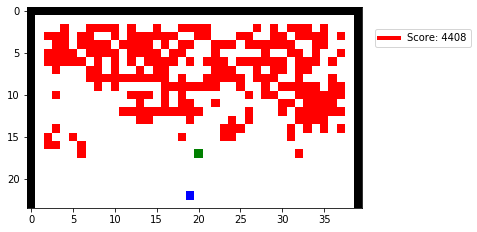

In [165]:
cmap = colors.ListedColormap(['white', 'black', 'red', 'blue', 'green'])
bounds=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(field, interpolation='nearest', origin='upper',
                    cmap=cmap, norm=norm)
custom_lines = [Line2D([0], [0], color='red', lw=4)]
plt.legend(custom_lines, [f'Score: {score}'], loc=(1.04, 0.8));

In [ ]:
15706

In [33]:
np.asarray(coords).reshape(-1, 3).max(axis=0)

array([39, 23,  4])

In [34]:
np.asarray(coords).reshape(-1, 3).min(axis=0)

array([-1,  0,  0])

In [38]:
np.mean(np.asarray(coords).reshape(-1,3), axis=0)

array([19.47866805, 11.4880333 ,  0.79396462])

In [16]:
tiles = 0
for i, d in enumerate(data):
    if (i+1)%3==0 and d==2:
        tiles += 1

In [17]:
tiles

335

In [11]:
sum(1 if d == 2 else 0 for i, d in enumerate(data) if i%3==0)

40

In [184]:
xpos = 0
ypos = 0
direction = 0
for i in range(1000000):
#     if i==0:
#         c.put(field.setdefault((xpos,ypos), 1))
#     else:
    c.put(field.setdefault((xpos,ypos), (0,None))[0])
    col = c.eval()
    turn = c.eval()
    field[(xpos,ypos)] = (col, turn)
    if turn==0:
        direction = (direction - 1) % 4
    elif turn==1:
        direction = (direction + 1) % 4
    else:
        raise ValueError('turn')
    #move
    if direction==0:
        ypos += 1
    elif direction==1:
        xpos += 1
    elif direction==2:
        ypos -= 1
    elif direction==3:
        xpos-=1
    else:
        raise ValueError('direction')

HaltException: 

In [121]:
import matplotlib.pyplot as plt

In [122]:
import numpy as np

In [123]:
ar = np.asarray([k for k,v in field.items() if v==1])

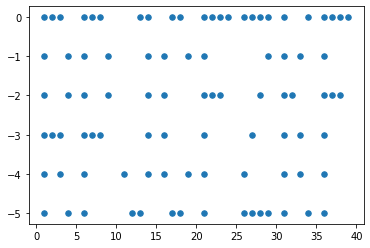

In [126]:
plt.scatter(ar[:,0],ar[:,1], s=30)

In [ ]:
RPJCFZKF

In [109]:
len(field)

2141

In [127]:
def run_intcode(inputs):
    c = Computer(state)
    for inp in inputs:
        c.put(inp)
    return c.eval()

In [128]:
def run_thrusters(phase_settings):
    out = 0
    for phase in phase_settings:
        #print(phase, out)
        program_inputs = [phase, out]
        out = run_intcode(program_inputs)
    return out

In [129]:
from itertools import permutations

In [130]:
def run():
    return max(
        run_thrusters(phase_perm) for phase_perm in permutations([0,1,2,3,4])
    )

In [131]:
run()

38834

# Part 2

In [7]:
from itertools import permutations

In [15]:
data = '''3,26,1001,26,-4,26,3,27,1002,27,2,27,1,27,26,27,4,27,1001,28,-1,28,1005,28,6,99,0,0,5'''

In [16]:
state = list(map(int, data.split(',')))

In [22]:
def run_loop(phase_settings):
    # initialization
    computers = []
    for phase in phase_settings:
        c = Computer(state)
        c.put(phase)
        computers.append(c)
    # run
    computers[0].put(0)
    cidx = 0
    last_out = 0
    while True:
        out = computers[cidx].eval()
        print(cidx, out)
        cidx = (cidx + 1) % len(computers)
        if out is not None:
            computers[cidx].put(out)
            last_out = out
        else:
            break
        #print(cidx, out)
    return last_out

In [18]:
def run():
    return max(
        run_loop(phase_perm) for phase_perm in permutations([9,8,7,6,5])
    )

In [19]:
run()

139629729